## LSTM Model
### First Part: Hyperparameter

c:\Users\cloudcine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


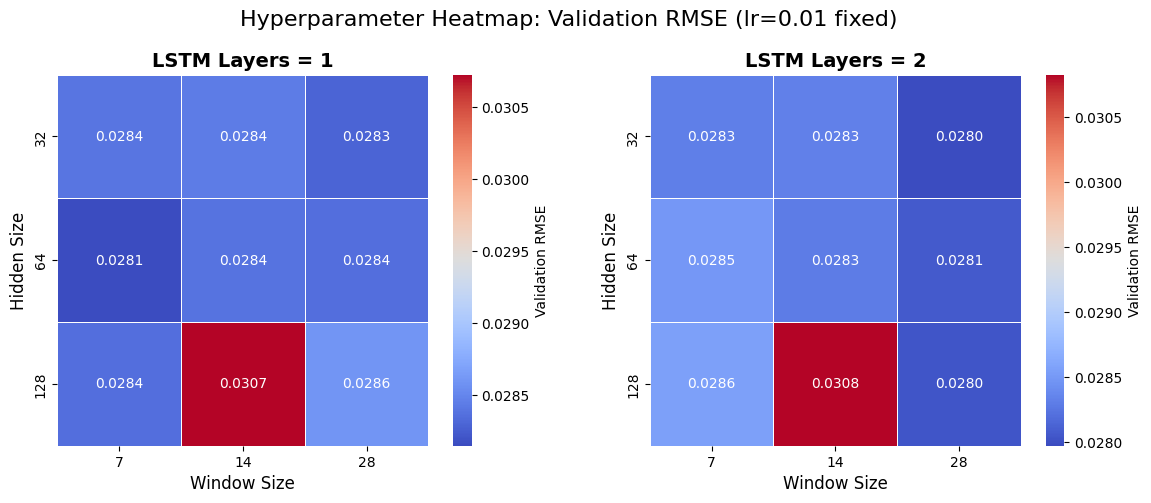

🔍 全局最优超参数（验证集）：
  num_layers: 2
  window_size: 28
  hidden_size: 32
  val_RMSE: 0.027970


In [21]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

fixed_lr = 0.01
# ----------------------------
# 1. 数据加载与划分（同前）
# ----------------------------
df = pd.read_csv('./data/BTC factors/addresses/BTC_1h_profit_relative.csv')
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df = df.sort_values(df.columns[0])
df.set_index(df.columns[0], inplace=True)
df = df.resample('D').mean()
start_time = '2021-01-01 00:00:00'
df = df[start_time:]

values = df["profit_relative"].values.astype(float).reshape(-1, 1)

# ======================================
#   先划分训练集与测试集（未归一化）
# ======================================
total_len = len(values)
train_test_split = int(total_len * 0.8)

train_full_raw = values[:train_test_split]
test_raw = values[train_test_split:]

# ======================================
#   在训练集上拟合 scaler，避免未来泄露
# ======================================
scaler = MinMaxScaler()
train_full_scaled = scaler.fit_transform(train_full_raw)
test_scaled = scaler.transform(test_raw)

# ======================================
#   再划分训练集与验证集
# ======================================
val_size = int(len(train_full_scaled) * 0.2)
train_data = train_full_scaled[:-val_size]
val_data = train_full_scaled[-val_size:]
test_data = test_scaled


# ----------------------------
# 2. 模型 & 评估函数（lr 固定 = 0.001）
# ----------------------------
def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def evaluate_params(ws, hs, nl, lr=fixed_lr, epochs=500):
    X_train, y_train = create_dataset(train_data, ws)
    X_val, y_val = create_dataset(val_data, ws)
    if len(X_train) == 0 or len(X_val) == 0:
        return np.nan  # 用 NaN 标记无效组合

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)

    model = LSTMModel(1, hs, nl)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        opt.zero_grad()
        loss = crit(model(X_train_t), y_train_t)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        rmse = np.sqrt(crit(model(X_val_t), y_val_t).item())
    return rmse

# ----------------------------
# 3. 搜索：固定 lr=0.001，遍历 (ws, hs, nl)
# ----------------------------
window_sizes = [7, 14, 28]
hidden_sizes = [32, 64, 128]
num_layers_list = [1, 2]

# 为两个层数分别构建 DataFrame（用于 heatmap）
heatmaps = {}

for nl in num_layers_list:
    matrix = np.full((len(hidden_sizes), len(window_sizes)), np.nan)
    for i, hs in enumerate(hidden_sizes):
        for j, ws in enumerate(window_sizes):
            rmse = evaluate_params(ws, hs, nl, lr=fixed_lr, epochs=500)
            matrix[i, j] = rmse
    # 构建 DataFrame
    df_heat = pd.DataFrame(
        matrix,
        index=hidden_sizes,      # y 轴
        columns=window_sizes     # x 轴
    )
    heatmaps[nl] = df_heat

# ----------------------------
# 4. 绘制两个热力图（并排）
# ----------------------------
plt.figure(figsize=(12, 5))

for idx, nl in enumerate([1, 2]):
    plt.subplot(1, 2, idx + 1)
    df_heat = heatmaps[nl]
    
    # 热力图：annot=True 显示数值，fmt=".4f" 保留4位小数
    sns.heatmap(
        df_heat,
        annot=True,
        fmt=".4f",
        cmap="coolwarm",        # 蓝→低 RMSE，红→高 RMSE
        cbar_kws={'label': 'Validation RMSE'},
        linewidths=0.5,
        square=True
    )
    
    plt.title(f'LSTM Layers = {nl}', fontsize=14, fontweight='bold')
    plt.xlabel('Window Size', fontsize=12)
    plt.ylabel('Hidden Size', fontsize=12)

plt.suptitle(f'Hyperparameter Heatmap: Validation RMSE (lr={fixed_lr} fixed)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 为 suptitle 留空间
plt.show()

# ----------------------------
# 5. 找出全局最优（可选）
# ----------------------------
all_results = []
for nl, df_heat in heatmaps.items():
    df_melt = df_heat.reset_index().melt(
        id_vars='index',
        var_name='window_size',
        value_name='val_rmse'
    )
    df_melt.rename(columns={'index': 'hidden_size'}, inplace=True)
    df_melt['num_layers'] = nl
    all_results.append(df_melt)

full_df = pd.concat(all_results, ignore_index=True)
best_row = full_df.loc[full_df['val_rmse'].idxmin()]
print("🔍 全局最优超参数（验证集）：")
print(f"  num_layers: {int(best_row['num_layers'])}")
print(f"  window_size: {int(best_row['window_size'])}")
print(f"  hidden_size: {int(best_row['hidden_size'])}")
print(f"  val_RMSE: {best_row['val_rmse']:.6f}")

### Hyperparameter
Note: Since increasing the number of layers did not significantly reduce the error and added more parameters, resulting in greater computational overhead and the risk of overfitting, we ultimately chose one layer as the optimal hyperparameter.

## Part two: Train and Test

In [13]:
import pandas as pd
import numpy as np

In [14]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('./data/BTC factors/addresses/BTC_1h_profit_relative.csv')
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
start_time = '2021-01-01 00:00:00'
df = df.sort_values('datetime')
df.set_index(df.columns[0], inplace=True)
df = df.resample('D').mean()    
df = df[start_time:]
values = df["profit_relative"].values.astype(float)
values =values.reshape(-1,1)
train_size = int(len(values) * 0.8)
train_data_raw = values[:train_size]
test_data_raw = values[train_size:]

# 2. 只用训练数据拟合scaler
scaler = MinMaxScaler()
train_data= scaler.fit_transform(train_data_raw)

# 3. 用训练数据的scaler转换测试数据
test_data= scaler.transform(test_data_raw)


c:\Users\cloudcine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [15]:
train_data_raw

array([[0.99705299],
       [0.99770999],
       [0.99769845],
       ...,
       [0.91175333],
       [0.92839402],
       [0.91967548]])

In [16]:
import torch
import torch.nn as nn

def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 7
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# 转为 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)              # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]                # 取最后一个时间步的输出
        out = self.fc(out)
        return out

model = LSTMModel()

In [17]:
criterion = nn.SmoothL1Loss()  # 平滑且对异常值不敏感
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
from tqdm import tqdm
epochs = 1000

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"\rEpoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}", end="")


  4%|▎         | 36/1000 [00:00<00:05, 175.87it/s]

Epoch [40/1000]  Loss: 0.001661

  7%|▋         | 72/1000 [00:00<00:05, 173.37it/s]

Epoch [80/1000]  Loss: 0.001224

 11%|█         | 109/1000 [00:00<00:05, 174.45it/s]

Epoch [120/1000]  Loss: 0.001102

 16%|█▋        | 163/1000 [00:00<00:04, 174.87it/s]

Epoch [160/1000]  Loss: 0.000982

 20%|█▉        | 199/1000 [00:01<00:04, 173.15it/s]

Epoch [200/1000]  Loss: 0.000876

 24%|██▎       | 235/1000 [00:01<00:04, 175.43it/s]

Epoch [240/1000]  Loss: 0.000806

 27%|██▋       | 271/1000 [00:01<00:04, 172.40it/s]

Epoch [280/1000]  Loss: 0.000763

 31%|███       | 307/1000 [00:01<00:04, 172.10it/s]

Epoch [320/1000]  Loss: 0.000723

 36%|███▌      | 360/1000 [00:02<00:03, 166.39it/s]

Epoch [360/1000]  Loss: 0.000686

 40%|███▉      | 397/1000 [00:02<00:03, 172.80it/s]

Epoch [400/1000]  Loss: 0.000655

 43%|████▎     | 433/1000 [00:02<00:03, 173.95it/s]

Epoch [440/1000]  Loss: 0.000628

 49%|████▊     | 487/1000 [00:02<00:02, 174.36it/s]

Epoch [480/1000]  Loss: 0.000632

 52%|█████▏    | 523/1000 [00:03<00:02, 174.99it/s]

Epoch [520/1000]  Loss: 0.000611

 56%|█████▌    | 559/1000 [00:03<00:02, 170.68it/s]

Epoch [560/1000]  Loss: 0.000596

 60%|█████▉    | 595/1000 [00:03<00:02, 172.88it/s]

Epoch [600/1000]  Loss: 0.000587

 63%|██████▎   | 631/1000 [00:03<00:02, 173.53it/s]

Epoch [640/1000]  Loss: 0.000582

 69%|██████▊   | 687/1000 [00:03<00:01, 178.20it/s]

Epoch [680/1000]  Loss: 0.000580

 70%|███████   | 705/1000 [00:04<00:01, 177.16it/s]

Epoch [720/1000]  Loss: 0.000580

 76%|███████▌  | 759/1000 [00:04<00:01, 175.66it/s]

Epoch [760/1000]  Loss: 0.000579

 80%|███████▉  | 795/1000 [00:04<00:01, 173.90it/s]

Epoch [800/1000]  Loss: 0.000579

 83%|████████▎ | 831/1000 [00:04<00:00, 174.61it/s]

Epoch [840/1000]  Loss: 0.000578

 88%|████████▊ | 885/1000 [00:05<00:00, 174.51it/s]

Epoch [880/1000]  Loss: 0.000578

 92%|█████████▏| 921/1000 [00:05<00:00, 173.18it/s]

Epoch [920/1000]  Loss: 0.000577

 96%|█████████▌| 957/1000 [00:05<00:00, 173.89it/s]

Epoch [960/1000]  Loss: 0.000577

100%|██████████| 1000/1000 [00:05<00:00, 173.27it/s]

Epoch [1000/1000]  Loss: 0.000576

In [18]:
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

# 反归一化到原始数值
train_pred = scaler.inverse_transform(train_pred.numpy())
y_train_true = scaler.inverse_transform(y_train.numpy())    

test_pred = scaler.inverse_transform(test_pred.numpy())
y_test_true = scaler.inverse_transform(y_test.numpy())


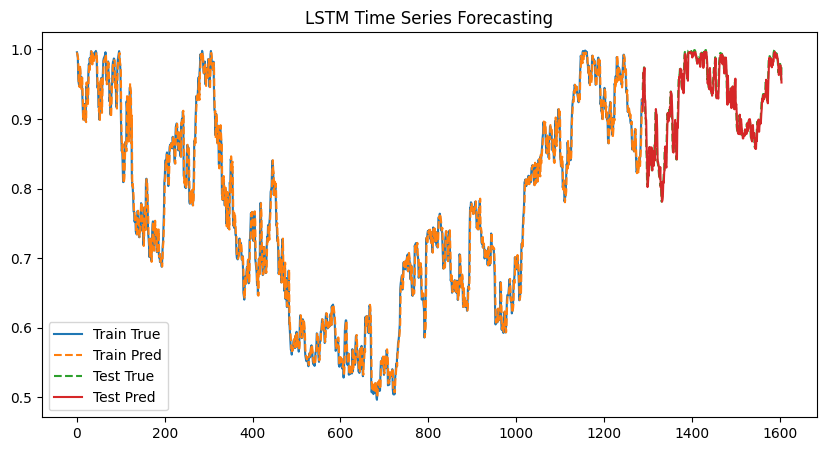

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(len(y_train_true)), y_train_true, label="Train True")
plt.plot(range(len(train_pred)), train_pred, linestyle="--",label="Train Pred")

plt.plot(range(len(y_train_true), len(y_train_true)+len(y_test_true)), y_test_true, linestyle="--",label="Test True")
plt.plot(range(len(y_train_true), len(y_train_true)+len(y_test_true)), test_pred,label="Test Pred")
plt.legend()
plt.title("LSTM Time Series Forecasting")
plt.show()


## Final result and comparison

In [20]:
MSE = np.mean((test_pred-y_test_true)**2)
MAE = np.mean(np.abs(test_pred-y_test_true))
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((test_pred-y_test_true)/y_test_true))
MASE = np.mean(np.abs(y_test_true-test_pred))/np.mean(np.abs(np.array(y_test_true[1:])-np.array(y_test_true[:-1])))
result= [{'Method':' LSTM','RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'MASE':MASE}]
result_frame = pd.DataFrame(result)
result_frame

,Method,RMSE,MAE,MAPE,MASE
0,LSTM,0.013293,0.009531,0.010428,1.013732
